# Land use Classification: Using Arcmap and Python

This exercise will walks us through image classification in ArcMap and python. We will classifiy a clipped portion of landsat 5 image, first using maximum likelihood classification in ArcMap and then using a Neural Network in Python.

__Output of each steps are provided to follow this exercise from any step. If you just want to skip to neural network portion click [here](#3).__


# Outline
- [ 1 - Data Preperation](#1)
  - [ 1.1 Dataset](#1.1)
  - [ 1.2 Preparing Training Samples](#1.2)
  - [ 1.3 Rasterizing the training samples](#1.3)
- [ 2 - Maximum likelihood classification in arcmap](#2)
- [ 3 - Neural Network classification in python](#3)
  - [ 3.1 Improrting libraries and cleaning data](#3.1)
      - [ 3.1.1 Importing libraries](#3.1.1)
      - [ 3.1.2 Reshaping Arrays](#3.1.2)
      - [ 3.1.3 Get Training Data](#3.1.3)
      - [ 3.1.4 Train - Test Split](#3.1.4)
  - [ 3.2 Building a model](#3.2)
  - [ 3.3 Training the model](#3.3)
  - [ 3.4 Saving and Loading the model](#3.4)
  - [ 3.5 Predicting using the model](#3.5)
      - [ 3.5.1 Model Evaluation](#3.5.1)
      - [ 3.5.2 Predict for the entire image](#3.5.2)
      - [ 3.5.3 Visualize the predicted classes](#3.5.3)
      - [ 3.5.4 Save the prediction as Raster](#3.5.4)


<a name = "1"></a>
## 1 - Data Preparation

<a name = "1.1"></a>
## 1.1 Dataset

We are using a portion of landsat 5 scene. [Landsat](https://www.usgs.gov/landsat-missions/landsat-5) images can be downloaded from [USGS EarthExplorer](https://earthexplorer.usgs.gov/) website. Then, using any desktop GIS or Remote Sensing software, the bands 1,2,3,4,5 and 7 can be merged into a single raster. Then the resulting raster can be clipped to the study area.

In this exercise, we are going to use the following image.

<div style = "hight:50%; width:50%;">
<figure>
<img src="landsatImage.png" alt = 'clipped landsat scene'>
<figcaption>Fig.1 : Clipped landsat image</figcaption>
</figure>    
</div>

<a name = "1.2"></a>
## 1.2 Preparing Training Samples

We will use the ArcMap Image Classification tool to create the training samples. If you don't have this tool  or software available, any other GIS software with this feature can be used.

__If you want to use the training samples provided, open the _Training Sample Manager_ and load the _trainingSample.shp_ file.__

First, open the __Image classification__ tool and start to __Draw Polygons__ as trainig class. If you have multiple images loaded, make sure in the dropdown of the __Image Classification__ tool, you have selected the correct image. Then draw several polygons for one class (For example: Water).

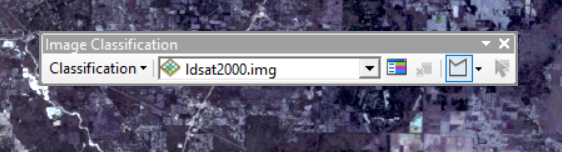

Second, open the __Training Sample Manager__ and merge the polygons to a single feature.

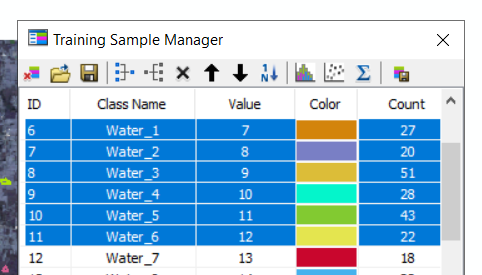

Now repeat step 1 and 2 for the next class. Make sure you change the __Value__ of each class so that it increases sequentially.
Do this for all the remaining classes.

Make sure you have enough training samples for each class. For better result, the number of training samples should be roughly proportional to the acutal area of each class in your data.

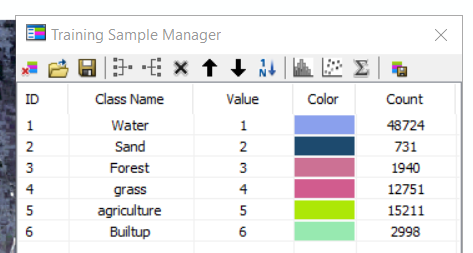

Just make sure that you have a well distributed training samples for each class.
If there are enough and well-distributed training samples, save them as for later use. Click the __Save training samples__ button in the __Training Sample Manger__ and save them in a appropriate location. These are the same as the _**trainingSample.shpe**_ file.

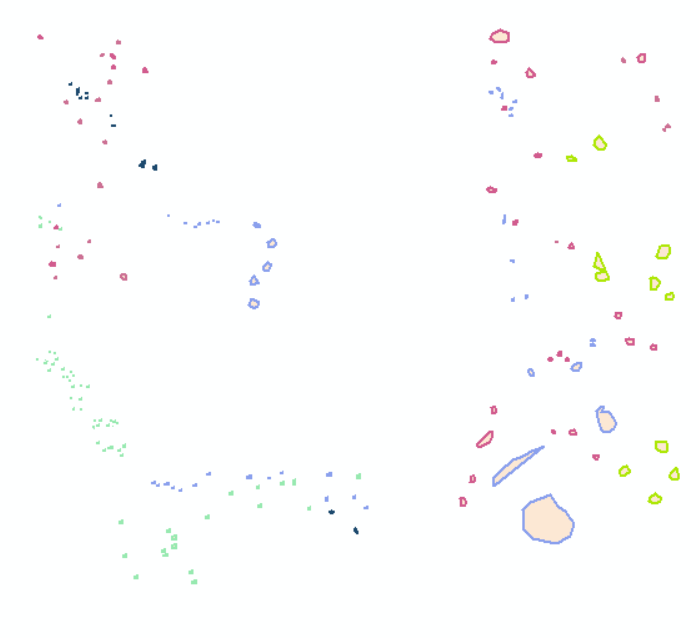

Now, on the right side of the __Training Sample Manger__, click the __Create signature file__ button. This will create  a signature file --a text file, that we will use for __Maximum likelihood classification__.


<a name = "1.3"></a>
## 1.3 Rasterizing the Training Samples

To used in the nural network, we will need to rasterize the training sample polygons. This can be done using __Polygon to Raster Tool__ in ArcMap.
Change the __Value Field__ to __Class Value__.

Make sure that you provide the actual clipped landsat image for the __cellsize__ parameter, __Processing extent__ envrionment variables __Extent__ and __Snap Raster__.

Make sure you end the name of output raster file with __.tif__.
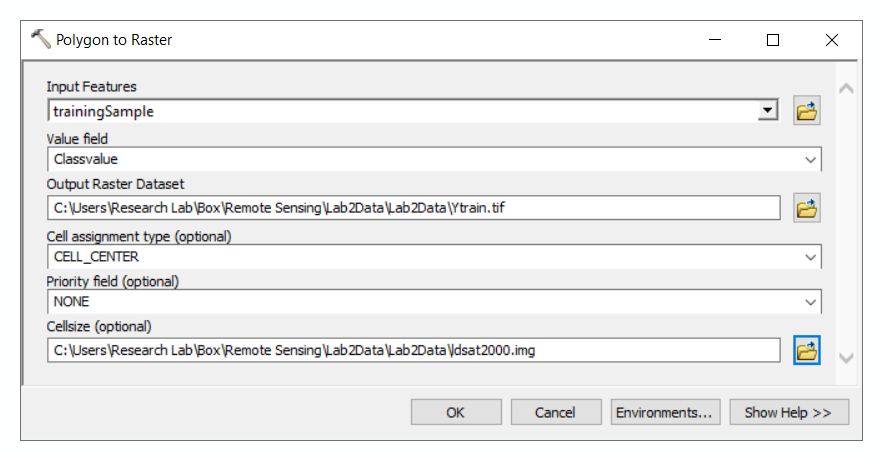
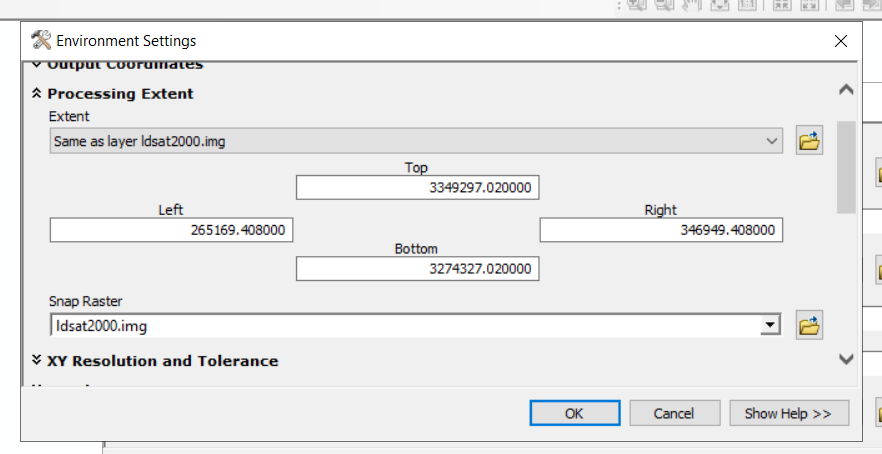

Finally, make sure the number of rows and columns of your actual clipped landsat image and the output just created are the same. This can be checked from __Properites__ --> __Source__ --> __Raster Information__ -> Columns and Rows.

<a name = "2"></a>
## 2 - Maximum Likelihood Classification in ArcMap

Find __Maximum Likelihood Classification__ tool either from search or from the __Classification__ drop-down of __Image Classification Tool__.

Select the clipped landsat image as the __input raster band__ and provide the signature file we created as input. For the output image name, make sure you end it with __.tif__.
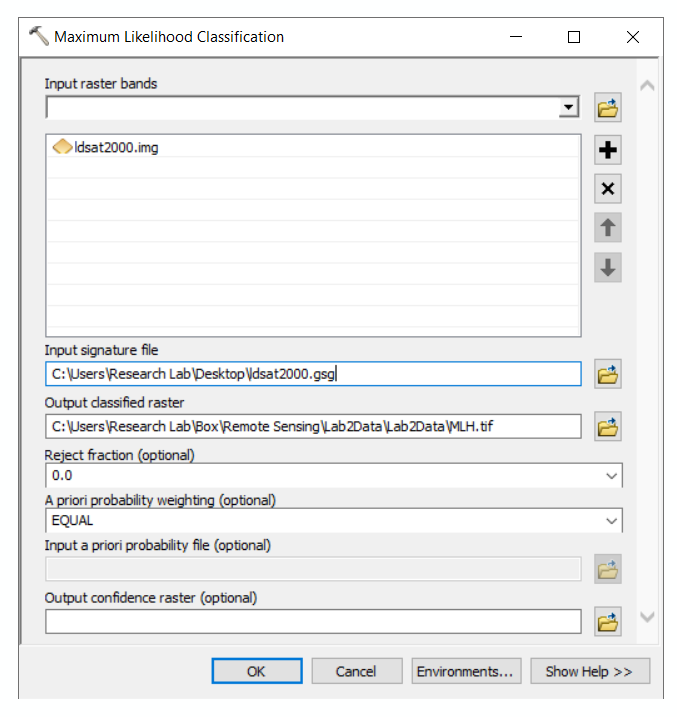

Apply the appropriate symboloy to the classified image. Here is an example output.
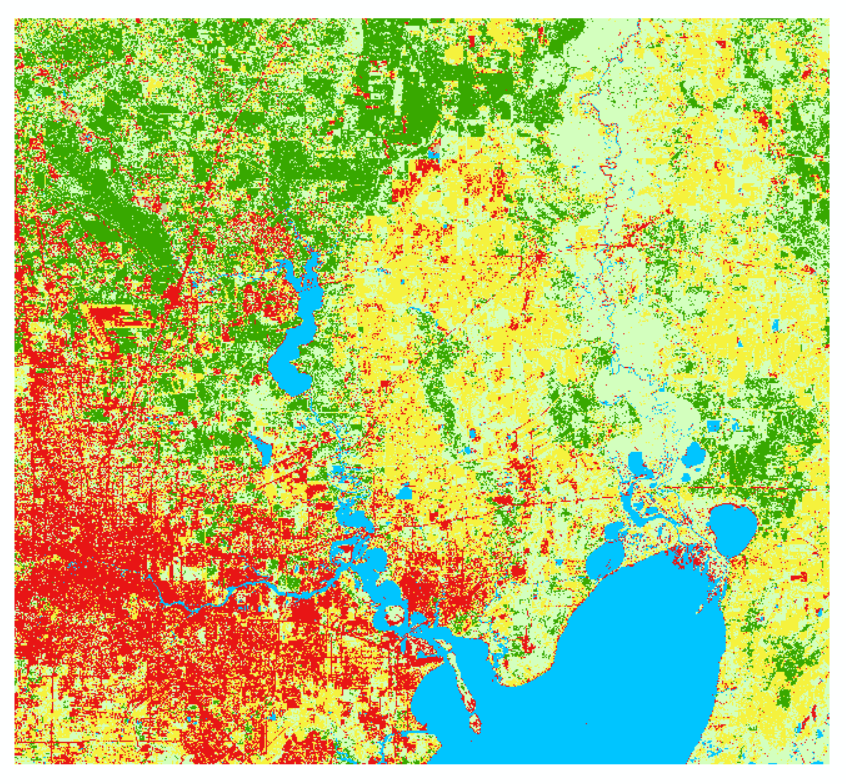


Next part will show how to use the training sample we created in step [1.3](#1.3) to perform classification using neural network in python.

<a name="3"></a>
## 3 - Neural Network Classification in Python
[TensorFlow](https://www.tensorflow.org/) is a free and open-source software library for machine learning and artificial intelligence and can be used in [Python](https://www.python.org/downloads/). First, let's install some packages we will need. We will use [__numpy__](https://numpy.org/install/) for manipulating arrays or matrices, [__gdal__](https://pypi.org/project/GDAL/) for reading and writing rasters, [__matplotlib__](https://matplotlib.org/) for making graphs and plotting images and __tensorflow__ for building and training neural network. if any of these libraries are not found, install them by running the respective __pip install__ commands. Be sure the remove the '#'.

In [ ]:
#! pip install numpy

In [ ]:
#! pip install gdal

In [ ]:
#! pip install matplotlib

In [ ]:
#! pip install tensorflow

<a name="3.1"></a>
## 3.1 Import Libraries and Cleaning Data

We will require gdal to read and write raster images. gdal will convert rasters to numpy arrays they they can be cleaned using numpy library. We will also need os module for chaning directories.
To use neural network we will use tensorflow library.

<a name = "3.1.1"></a>
## 3.1.1 Importing Libraries

In [2]:
import os
import numpy as np
from osgeo import gdal

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)


In [3]:
# Make sure to change the directory to appropriate folder
os.chdir(r'<appropriate folder>\Land use classification using ArcMap and Python')

In [4]:
xds = gdal.Open('ldsat2000.img')
yds = gdal.Open('Ytrain0.tif')

In [5]:
X = xds.ReadAsArray()
y = yds.ReadAsArray()

In [6]:
print(f'Shape of input data is : {X.shape}.')

Shape of input data is : (6, 2499, 2726).


In [7]:
print(f'Shape of expected training classes is {y.shape}.')

Shape of expected training classes is (2499, 2726).


<a name="3.1.2"></a>
## 3.1.2 Reshaping Arrays
The shape of input data (6, 2499, 2726) means that there are 6 bands, 2499 rows and 2726 columns in the input data. We want to reshape this data to a table-like format where each row represents one pixel and each column represents one band. This will be accomplished in two steps.
First, axis 0 which indicates number of bands, to the axis 2.
Second, reshape that array to array of shape _(n_row * n_cols, n_bands)_.

In [8]:
Xtab = np.moveaxis(X,0,2)
Xtab.shape

(2499, 2726, 6)

In [9]:
Xtab = Xtab.reshape(Xtab.shape[0]*Xtab.shape[1], Xtab.shape[2])
Xtab.shape

(6812274, 6)

Similary we will resahpe y in to an array of shape _(n_rows * n_cols, 1)_ .

In [10]:
y = y.reshape(y.shape[0]*y.shape[1],1)
y.shape

(6812274, 1)

<a name = '3.1.3'></a>
## 3.1.3 Get training data
Now our data is in the structure we want. But we will need to get the training data which is a subset of our whole data. The array y shows the corresponding classes of our training data. To get the training data only, we need to remove the NoData from both Xtab and y arrays. We will see what value represents NoData in yds.

In [11]:
nodata = yds.GetRasterBand(1).GetNoDataValue()
nodata

15.0

As we can see, the value 15 represents the NoData value in our trainig y data. We will remove the nodata values from our trainig data now.

In [12]:
dataIndex = (y != 15)

In [13]:
yclean = y[dataIndex]
Xclean = Xtab[dataIndex.flatten(),:]

Also, if we look at the unique class values in our yclean data, it ranges from 1 to 6. As indexing in python starts from zero, we will want our yclean to range from 0 to 5. We can this by subtracting 1 from yclean and saving this back to yclean.

In [14]:
np.unique(yclean)

array([1, 2, 3, 4, 5, 6], dtype=uint8)

In [15]:
yclean = yclean - 1

In [16]:
np.unique(yclean)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

<a name = "3.1.4"></a>
## 3.1.4 Train - Test Split
We will use the 80% of the cleaned data to train the model and the remaining 20% to validate the model. For this, we will use the [__argsort__](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) method and indexing for numpy arrays for randomly spliting data into training set and test set. We will also set the random seed to zero for consistency.

In [18]:
np.random.seed(0)
indices = np.random.sample(len(yclean))
indices

array([0.5488135 , 0.71518937, 0.60276338, ..., 0.31775503, 0.17761643,
       0.27058917])

In [19]:
sortedIndices = np.argsort(indices)

In [21]:
testlength = int(0.2*len(yclean))
testlength

16473

In [22]:
trainIndices = sortedIndices[testlength:]
testIndices = sortedIndices[:testlength]

In [23]:
Xtrain = Xclean[trainIndices]
ytrain = yclean[trainIndices]

Xtest = Xclean[testIndices]
ytest = yclean[testIndices]

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((65896, 6), (65896,), (16473, 6), (16473,))

Let's see how many unique classes are in our dataset.

In [24]:
np.unique(ytrain, return_counts = True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([39029,   577,  1556, 10175, 12106,  2453], dtype=int64))

In [25]:
np.unique(ytest, return_counts = True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([9656,  151,  395, 2590, 3100,  581], dtype=int64))

<a name = "3.2"></a>
## 3.2 Building a model
Now that our data is cleaned, we can build a neural network model using tensorflow. We will build a neural network with 2 hidden layers. We should provide the expected shape of input to the model. As we can see, each row in X will have 6 columns, so the expected input shape is (6,). Also, for output layer the number of nodes should be same as the number of classes that we want. As there are 6 classes in our ytrain data, that should be the number of nodes in output layer.

In [26]:
tf.random.set_seed(1234)
model = Sequential(
    [               
        tf.keras.Input(shape=(6,)),
        Dense(25, activation='relu', name = "L1"),
        Dense(15, activation='relu',  name = "L2"),
        Dense(6, activation='linear', name = "L3"),  # Number of unique classes 
    ], name = "my_model" 
)

In [27]:
model.build()
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 25)                175       
                                                                 
 L2 (Dense)                  (None, 15)                390       
                                                                 
 L3 (Dense)                  (None, 6)                 96        
                                                                 
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


There are 3 layers in our model and a total of 661 parameters.


We are now ready to train.

<a name = "3.3"></a>
## 3.3 Training the model
Before training the model, we need to compile it. We will use _Sparse Categorical Cross entropy_ as a loss metric, which the model will try to minimize in successive iterations. We will use_ Adam_ optimzer for faster convergence.

The learning rate is a __hyperparameter__ which controls how fast the model parameters are updated in each iteration. For a bigger problem, different techniques are used to find a suitable value of this hyperparameter. Here we will use 0.001, wchich works for our case.

The __epoch__ refers to the number of times the model will see the entire training data. We will use 40 in this case.

Depending upon the computing resource, this may take some time. On my computer (16 GB RAM, I7), it took around 120 seconds. 

In [28]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    Xtrain,ytrain,
    epochs=40,
)

Epoch 1/40
2060/2060 [==============================] - 3s 1ms/step - loss: 0.4053
Epoch 2/40
2060/2060 [==============================] - 2s 1ms/step - loss: 0.2466
Epoch 3/40
2060/2060 [==============================] - 2s 994us/step - loss: 0.2326
Epoch 4/40
2060/2060 [==============================] - 2s 1ms/step - loss: 0.2197
Epoch 5/40
2060/2060 [==============================] - 2s 977us/step - loss: 0.2103
Epoch 6/40
2060/2060 [==============================] - 2s 977us/step - loss: 0.2067
Epoch 7/40
2060/2060 [==============================] - 2s 993us/step - loss: 0.2043
Epoch 8/40
2060/2060 [==============================] - 2s 1ms/step - loss: 0.2007
Epoch 9/40
2060/2060 [==============================] - 2s 1ms/step - loss: 0.1977
Epoch 10/40
2060/2060 [==============================] - 2s 1ms/step - loss: 0.1944
Epoch 11/40
2060/2060 [==============================] - 2s 946us/step - loss: 0.1943
Epoch 12/40
2060/2060 [==============================] - 2s 1ms/step - loss

Let's visualize the how the loss is chaning over 40 epochs. Notice that, it decreases rapidly first, then gradually tends to flatten out. If we train more, it will keep on decreasing but the rate of change of decrease will also get smaller.

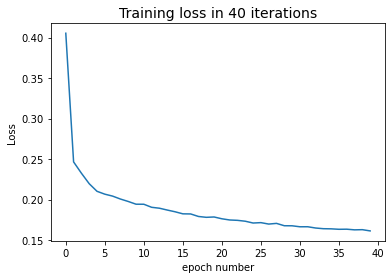

In [29]:
loss = history.history['loss']
plt.plot(loss)
plt.title("Training loss in 40 iterations", fontsize = 14)
plt.xlabel('epoch number')
plt.ylabel('Loss')
plt.show()

<a name = "3.4"></a>
## 3.4 Saving and loading model
When you train a model, it is usually a good idea to save it so that you can later use it just for inference without training again. Following section shows how to save a model to current working directory and how to load a saved model.

In [30]:
# Save model
model.save('my_model.tf')

# Load model
new_model = tf.keras.models.load_model('my_model.tf')

<a name = "3.5"></a>
## 3.5 Predicting using the model
Now we have trained our model, lets see how well it does with the training data. First, the model prediction will give an aray of 6 numbers for each input X, which we will pass through softmax method of nn class of tensorflow to get a relative probability of that row belonging to each of the 6 classes. Then we well use argmax method of numpy class to find the class with maximum probability for each row (axis = 1). The we will see what fraction of our prediction were same as the actual class.

In [31]:
predictionsTrain = model.predict(Xtrain)

2060/2060 [==============================] - 2s 820us/step


In [32]:
predictionTrain_probs = tf.nn.softmax(predictionsTrain)

In [33]:
ypredTrain = np.argmax(predictionTrain_probs, axis = 1)

In [34]:
training_accuracy = np.mean(ypredTrain == ytrain)

It seems our model is doing pretty well on the training data. Lets see how well it does for unseed data.
We will then apply the model to the entire data we have, save it as a tif file using gdal which can be compared with the original image in any GIS software.

<a name = "3.5.1"></a>
## 3.5.1 Model Evaluation
Let's test our model performence in the test data.

In [35]:
predictionsTest = model.predict(Xtest)
predictionTest_probs = tf.nn.softmax(predictionsTest)
ypredTest = np.argmax(predictionTest_probs, axis = 1)
test_accuracy = np.mean(ypredTest == ytest)

515/515 [==============================] - 0s 773us/step


In [36]:
print(f'The training accuracy is : {np.round(100*training_accuracy, 2)} %. ')
print(f'The test accuracy is : {np.round(100*test_accuracy,2)} %. ')

The training accuracy is : 94.27 %. 
The test accuracy is : 94.12 %. 


It seems that our model is doing well on both the training and test data with training accuray of 94.27 % and test accuracy of 94.12 %. If we assume that human can classify land use with accuracy of 99 % (just an example), then our model still has room for more than 5 % improvement. This shows that model is suffereing from __high-bias__, which can be minimized by using a __deeper neural network__, __training for more epochs__, or using __more variables__ such as band indices for classification.

If we assume that human level accuracy is 94.3 %, then our model is doing really well on the training data, but there is room for improvement on test data. This would constitute a __high-variance__ problem, which can be addressed by adding __more training examples__ or by __increasing regularization__.

We will leave this bias-variance analysis for the future. Now we well see what the classification result looks like on the entire image.

<a name = "3.5.2"></a>
## 3.5.2 Predict for the entire data

We already have our entire data reshaped and saved in the variable Xtab. We can direclty apply the model to this data. Then we will need to reshape the output to the shape of original input data before we save it as a raster.

In [37]:
allPredictions = model.predict(Xtab)

212884/212884 [==============================] - 174s 817us/step


In [38]:
allPredictions_probs = tf.nn.softmax(allPredictions)

In [39]:
Ypred = np.argmax(allPredictions_probs, axis = 1)

Earlier, we subtracted 1 from ytrain to make it range from 0 to 5. If we want to our classes to range from 1 to 6 we can simply add 1 to the predicted classes, and then we will reshape it to the desired shape.

In [40]:
Ypred = Ypred + 1
Ypred.shape

(6812274,)

In [41]:
Ypred = Ypred.reshape(yds.ReadAsArray().shape)

<a name = "3.5.3"></a>
## 3.5.3 Visualize the predicted classes

In [42]:
cmap=ListedColormap(['#2023ee', '#ededed', '#4caf50','#8bcd8d', 'yellow', '#ff3f14'])

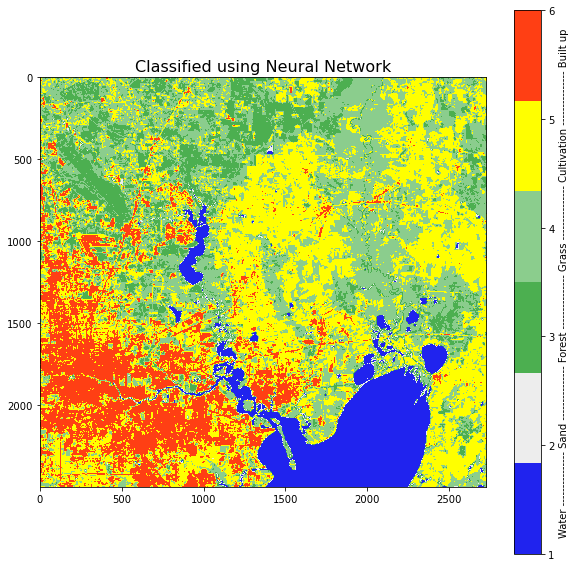

In [43]:
plt.figure(figsize = (10,10))
plt.imshow(Ypred, cmap = cmap)
plt.colorbar(label = ' --------------- '.join(['Water', 'Sand', 'Forest', 'Grass', 'Cultivation', 'Built up' ]))
plt.title('Classified using Neural Network', fontsize = 16)
plt.show()

Let's also visualize our result from [Maximum Likelihood Classification](#2) for a comparision.

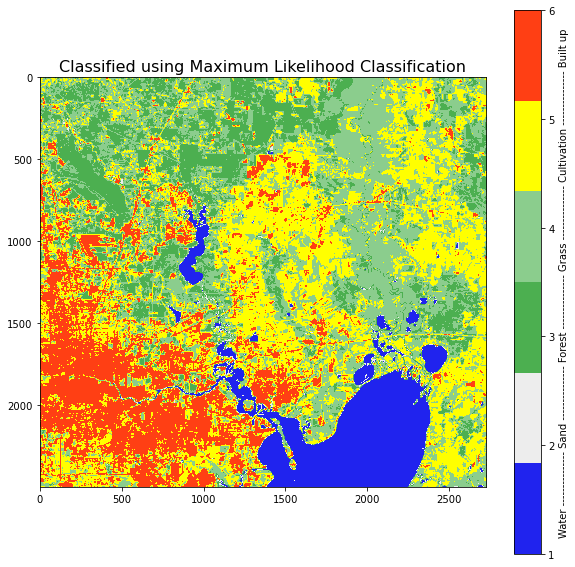

In [44]:
ds = gdal.Open('fromArcClassified.tif')
ds_array = ds.ReadAsArray()
plt.figure(figsize = (10,10))
plt.imshow(ds_array, cmap = cmap)
plt.colorbar(label = ' --------------- '.join(['Water', 'Sand', 'Forest', 'Grass', 'Cultivation', 'Built up' ]))
plt.title('Classified using Maximum Likelihood Classification', fontsize = 16)
plt.show()

Let's show both the images side by side for better comparision.

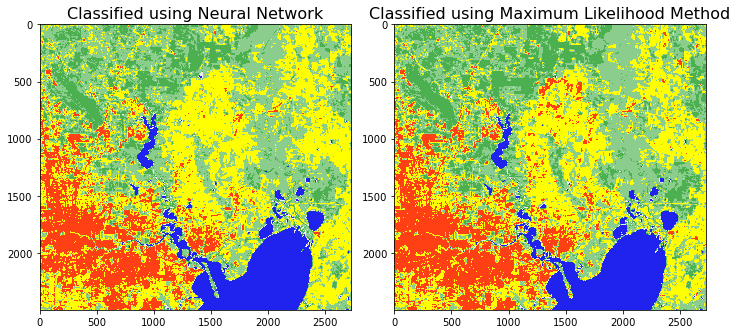

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].imshow(Ypred, cmap = cmap)
axes[0].set_title('Classified using Neural Network', fontsize = 16)
axes[1].imshow(ds_array, cmap = cmap)
axes[1].set_title('Classified using Maximum Likelihood Method', fontsize = 16)

fig.tight_layout()

<a name = "3.5.4"></a>
## 3.5.4 Save the prediction as Raster
We can use gdal to write the prediction as a raster. First we will create a _geotiff_ dataset, take its first band and write the prediction to it. Then set the coordinate reference system and geotransform which will  be the same as that of inpput _xds_. Finally, we need to call FlushCache method so that changes will be written on disk and that can be properly opened in other software.

In [47]:
driver_gtiff = gdal.GetDriverByName('GTiff')

ds_create = driver_gtiff.Create('predicted.tif', xsize=Ypred.shape[1], ysize=Ypred.shape[0], bands=1)
ds_create.GetRasterBand(1).WriteArray(Ypred)

ds_create.SetProjection(xds.GetProjection())
ds_create.SetGeoTransform(xds.GetGeoTransform())
ds_create.GetRasterBand(1).FlushCache()
ds_create.FlushCache()

__Congratulations!__ Now you know how to use neural networks to classify satellite images. Good luck on your learning journey.